***Лабораторная работа 3***

**Грамматика G2**

    <выражение> ->
            <арифметическое выражение> <операция отношения> <арифметическое выражение> |
            <арифметическое выражение>

    <арифметическое выражение> ->
            <арифметическое выражение> <операция типа сложения> <терм> | <терм>

    <терм> ->
            <терм> <операция типа умножения> <фактор> | <фактор>

    <фактор> ->
            <идентификатор> | <константа> | (<арифметическое выражение>)

    <операция отношения> ->
            < | <= | = | <> | > | >=

    <операция типа сложения> ->
            + | -

    <операция типа умножения> ->
            * | /

**Грамматика G2 (без левой рекурсии)**

    <выражение> -> 
            <арифметическое выражение> <операция отношения> <арифметическое выражение> | 
            <арифметическое выражение>
    
    <арифметическое выражение> -> 
            <терм> | <терм> <арифметическое выражение'>
    
    <арифметическое выражение'> -> 
            <операция типа сложения> <терм> | <операция типа сложения> <терм> <арифметическое выражение'>
    
    <терм> -> 
            <фактор> | <фактор> <терм'>
    
    <терм'> -> 
            <операция типа умножения> <фактор> | <операция типа умножения> <фактор> <терм'>
    
    <фактор> -> 
            <идентификатор> | <константа> | (<арифметическое выражение>)
    
    <операция отношения> -> 
            < | <= | = | <> | > | >=
    
    <операция типа сложения> -> 
            + | -
    
    <операция типа умножения> -> 
            * | /

In [1]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

from graphviz import Digraph
from typing import Type, List

position = 0

In [2]:
class Node:
    value = ""
    children: List[Type["Node"]]

    def __init__(self, data) -> Type["Node"]:
        self.value = data
        self.children = []

    def print(self, tree=None, parent_value="", id="main"):
        if not tree:
            tree = Digraph()
            tree.node_attr["shape"] = "plain"

        tree.node(id, str(self.value))
        if parent_value:
            tree.edge(parent_value, id)

        for i, child in enumerate(self.children):
            child.print(tree, id, id + "." + str(i))

        return tree
    
def parse_lex(tree: Node, lexemes: List[str], lex: str) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position] == lex:
        tree.children.append(Node(lex))
        position += 1
        return True

    return False

**Парсинг Грамматики**

In [3]:
def parse_operation_type_multiplication(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position] in ['*', '/']:
        new_node = Node("<операция типа умножения>")
        new_node.children.append(Node(lexemes[position]))
        tree.children.append(new_node)
        position += 1
        return True
    return False

def parse_operation_type_addition(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position] in ['+', '-']:
        new_node = Node("<операция типа сложения>")
        new_node.children.append(Node(lexemes[position]))
        tree.children.append(new_node)
        position += 1
        return True
    return False

def parse_operation_relation(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position] in ['<', '<=', '=', '<>', '>', '>=']:
        new_node = Node("<операция отношения>")
        new_node.children.append(Node(lexemes[position]))
        tree.children.append(new_node)
        position += 1
        return True
    return False

def parse_identifier(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    if lexemes[position].isalpha() and lexemes[position] not in ['begin', 'end']:
        new_node = Node("<идентификатор>")
        new_node.children.append(Node(lexemes[position]))
        tree.children.append(new_node)
        position += 1
        return True
    return False

def parse_const(tree: Node, lexemes: List[str]) -> bool:
    global position
    if position >= len(lexemes):
        return False

    try:
        value = int(lexemes[position])
    except:
        try:
            value = float(lexemes[position])
        except:
            return False

    new_node = Node("<константа>")
    new_node.children.append(Node(value))
    tree.children.append(new_node)
    position += 1
    return True

def parse_factor(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<фактор>")
    if parse_identifier(new_node, lexemes):
        tree.children.append(new_node)
        return True
    elif parse_const(new_node, lexemes):
        tree.children.append(new_node)
        return True
    elif parse_lex(new_node, lexemes, '('):
        if parse_arithmetic_expression(new_node, lexemes):
            if parse_lex(new_node, lexemes, ')'):
                tree.children.append(new_node)
                return True

    return False

def parse_therm_prime(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<терм’>")
    if parse_operation_type_multiplication(new_node, lexemes):
        if parse_factor(new_node, lexemes):
            if parse_therm_prime(new_node, lexemes):
                tree.children.append(new_node)
                return True

        return False

    return True

def parse_therm(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<терм>")
    if parse_factor(new_node, lexemes):
        if parse_therm_prime(new_node, lexemes):
            tree.children.append(new_node)
            return True
    
    return False

def parse_arithmetic_expression_prime(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<арифметическое выражение’>")
    if parse_operation_type_addition(new_node, lexemes):
        if parse_therm(new_node, lexemes):
            if parse_arithmetic_expression_prime(new_node, lexemes):
                tree.children.append(new_node)
                return True
        return False
    
    return True

def parse_arithmetic_expression(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<арифметическое выражение>")
    if parse_therm(new_node, lexemes):
        if parse_arithmetic_expression_prime(new_node, lexemes):
            tree.children.append(new_node)
            return True

    return False

def parse_expression(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<выражение>")
    if parse_arithmetic_expression(new_node, lexemes):
        if parse_operation_relation(new_node, lexemes):
            if parse_arithmetic_expression(new_node, lexemes):
                tree.children.append(new_node)
                return True
            # else:
            return False

        tree.children.append(new_node)
        return True

    return False

**Блок кода в стиле Алгол-Паскаль**
    
    <программа> –>
            <блок>
    
    <блок> –>
            begin <список операторов> end
    
    <список операторов> –>
            <оператор> | <список операторов> ; <оператор>
    
    <оператор> –>
            <идентификатор> := <выражение>

**Блок кода в стиле Алгол-Паскаль (без левой рекурсии)**
    
    <программа> –>
            <блок>
    
    <блок> –>
            begin <список операторов> end
    
    <список операторов> –>
            <оператор> <список операторов’ >
    
    <список операторов’> –>
            ; <оператор> <список операторов’> | ε
    
    <оператор> –>
            <идентификатор> := <выражение>


**Парсинг программы**

In [4]:
def parse_operator(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<оператор>")
    if parse_identifier(new_node, lexemes):
        if parse_lex(new_node, lexemes, ':='):
            if parse_expression(new_node, lexemes):
                tree.children.append(new_node)
                return True

    return False

def parse_operator_list_prime(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<список операторов’>")
    if parse_lex(new_node, lexemes, ';'):
        if parse_operator(new_node, lexemes):
            if parse_operator_list_prime(new_node, lexemes):
                tree.children.append(new_node)
                return True
        return False
    
    return True

def parse_operator_list(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<список операторов>")
    if parse_operator(new_node, lexemes):
        if parse_operator_list_prime(new_node, lexemes):
            tree.children.append(new_node)
            return True

    return False

def parse_block(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<блок>")
    if parse_lex(new_node, lexemes, 'begin'):
        if parse_operator_list(new_node, lexemes):
            if parse_lex(new_node, lexemes, 'end'):
                tree.children.append(new_node)
                return True
    
    return False

def parse_program(tree: Node, lexemes: List[str]) -> bool:
    new_node = Node("<программа>")
    if parse_block(new_node, lexemes):
        tree.children.append(new_node)
        return True

    return False

In [5]:
def tokenize(inp: str) -> List[str]:
    tokens = []
    cur_pos = 0
    while cur_pos < len(inp):
        if inp[cur_pos: min(cur_pos + 5, len(inp))] in ['begin']:
            tokens += [inp[cur_pos: min(cur_pos + 5, len(inp))]]
            cur_pos += 5
        elif inp[cur_pos: min(cur_pos + 3, len(inp))] in ['end']:
            tokens += [inp[cur_pos: min(cur_pos + 3, len(inp))]]
            cur_pos += 3
        elif inp[cur_pos: min(cur_pos + 2, len(inp))] in ['<>', '<=', '>=', ':=']:
            tokens += [inp[cur_pos: min(cur_pos + 2, len(inp))]]
            cur_pos += 2
        elif inp[cur_pos] in ['=', '<', '>', '+', '-', '*', '/', '(', ')', ';']:
            tokens += [inp[cur_pos]]
            cur_pos += 1
        elif inp[cur_pos] in [' ', '\t', '\n', '\r']:
            cur_pos += 1
        else:
            start_position = cur_pos
            while cur_pos < len(inp) and (inp[cur_pos].isalpha() or inp[cur_pos].isnumeric() or inp[cur_pos] in ["_", '.']):
                cur_pos += 1
            tokens += [inp[start_position: cur_pos]]
            if start_position == cur_pos:
                print("ERROR")
                break
    return tokens

**Пример работы**

['22.228', '/', 'bro', '/', '12', '<=', '(', '1024', '*', '(', '1.1', '+', 'waka', ')', '-', '142', ')', '+', '22', '/', '5.6', '/', '2', '+', '1']


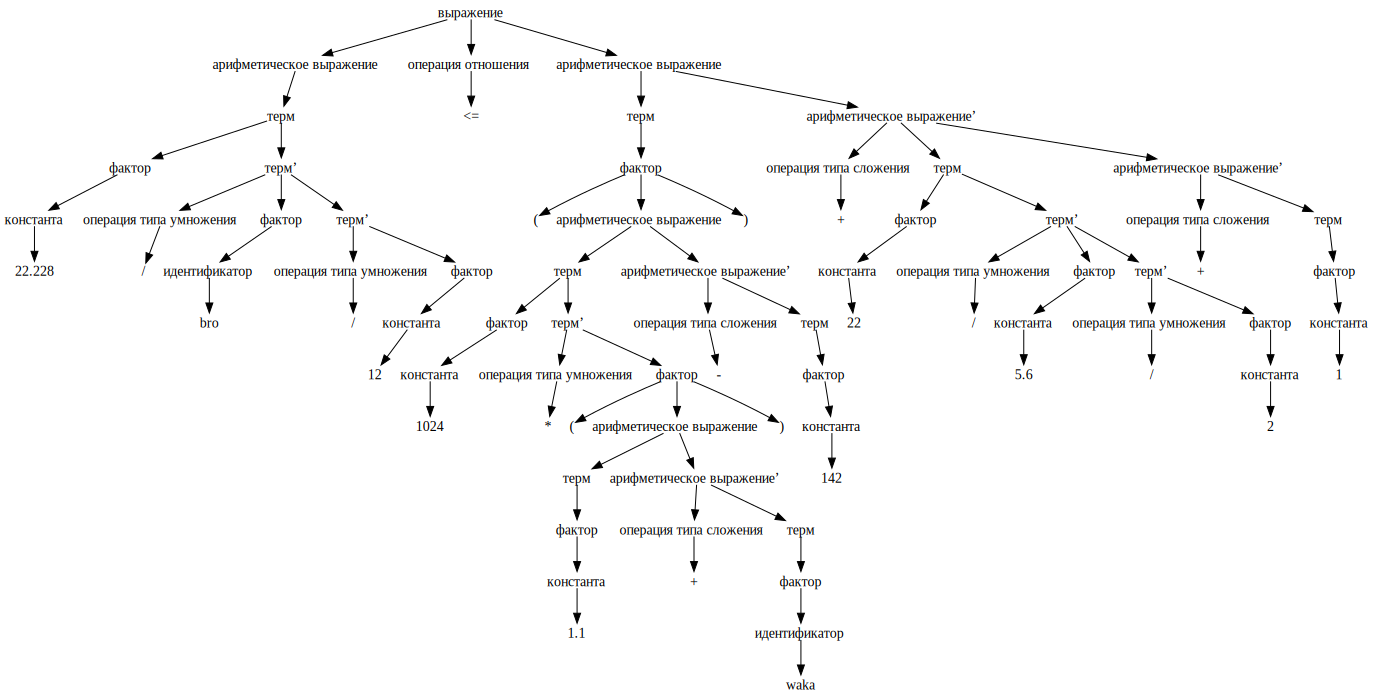

In [6]:
code = ''' 
    22.228/bro  / 12 <= (1024*(1.1 + waka)-142) + 22/5.6 / 2 +1
'''

tokens = tokenize(code)
print(tokens)

tree = Node("root")
if not parse_expression(tree, tokens) or position != len(tokens):
    raise SystemExit("PARSE ERROR")

tree.children[0].print()

['begin', 'a', ':=', 'b', '<', '2.8', ';', 'darow', ':=', '1', '+', '2', ';', 'thug', ':=', '1', '+', 'bebe', 'end']


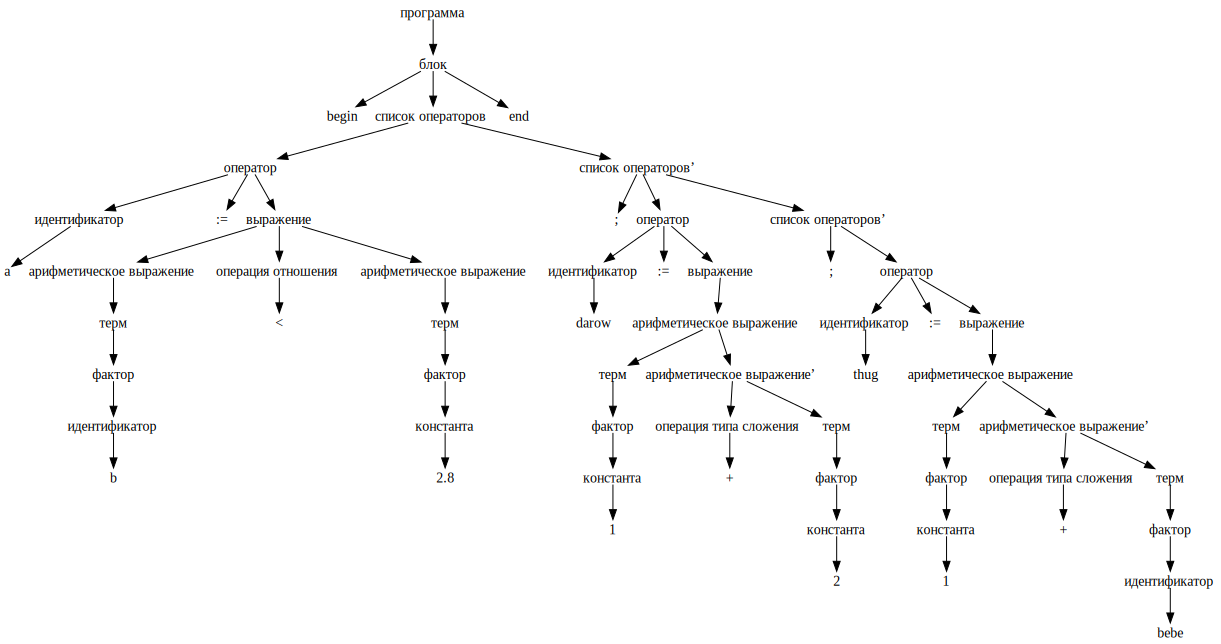

In [7]:
code = '''
begin
    a := b < 2.8;
    darow:=1+2;
    thug := 1+bebe
end
'''

tokens = tokenize(code)
print(tokens)

tree = Node("root")
position = 0
if not parse_program(tree, tokens) or position != len(tokens):
    raise SystemExit("PARSE ERROR")

tree.children[0].print()